### Imports and Setup

In [1]:
import os
import pickle
import json
import copy
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from utils.evaluate import evaluate_model
from scipy.stats import mode

DATA_DIR = "./data"
PICKLE_DIR = "./results/pickles"
SUMMARY_DIR = "./results/summaries"
VISUALS_DIR = "./results/visuals/ensemble"
os.makedirs(VISUALS_DIR, exist_ok=True)

# ====== Pickle Setup ======
# want to test or debug?          -> USE_PICKLE = False
# want to use existing pickle?    -> USE_PICKLE = True, OVERWRITE_PICKLE = False
# want to rerun & overwrite?      -> USE_PICKLE = True, OVERWRITE_PICKLE = True

USE_PICKLE = True
OVERWRITE_PICKLE = False

RUN_LIMIT = None # optional run limiter for testing
DEBUG = False # optional flag for previewing pickle contents before reuse
DELTA_AUC_WARN_THRESHOLD = 0.02 # flag ensemble mismatch if summary vs full AUC differ by this much

# dynamically picks a reference dataset (e.g., first one alphabetically)
dataset_names = sorted([
    f.replace(".csv", "")
    for f in os.listdir(DATA_DIR)
    if f.endswith(".csv") and not f.startswith(".")
])

if not dataset_names:
    raise ValueError("No dataset CSV files found in DATA_DIR.")

REFERENCE_DATASET = dataset_names[0]  # safe default for extracting synced splits


### I/O & Data Loading Functions

In [2]:
# detects all datasets based on pickle filenames
def detect_datasets(pickle_dir):
    return sorted([
        fname.replace("feature_eng_output_", "").replace(".pkl", "")
        for fname in os.listdir(pickle_dir)
        if fname.startswith("feature_eng_output_") and fname.endswith(".pkl")
    ])
    
# loads full pickled feature engineering output for a dataset
def load_feature_eng_output(dataset):
    path = os.path.join(PICKLE_DIR, f"feature_eng_output_{dataset}.pkl")
    with open(path, "rb") as f:
        return pickle.load(f)

# retrieves test set indices from the reference dataset
def get_synced_test_indices(reference_dataset):
    with open(os.path.join(PICKLE_DIR, f"feature_eng_output_{reference_dataset}.pkl"), "rb") as f:
        data = pickle.load(f)
    return [test for _, test in data["split_indices"]]

# validates presence and structure of best_model_info
def load_best_model_info(data, dataset):
    info = data.get("best_model_info")
    if not info:
        raise ValueError(f"Missing 'best_model_info' for dataset '{dataset}'.")

    required_keys = ["model_name", "method", "n_features", "AUC"]
    for k in required_keys:
        if k not in info:
            raise KeyError(f"Missing key '{k}' in best_model_info for dataset '{dataset}'.")

    return info


### Extracting & Validating Run Predictions

In [3]:
# extracts per-run predictions and validates alignment to reference splits
def extract_runs_and_validate(data, run_key, dataset_name, synced_indices=None):
    if run_key in data.get("feature_selection_runs", {}):
        runs = data["feature_selection_runs"][run_key]
    elif run_key in data.get("feature_extraction_runs", {}):
        runs = data["feature_extraction_runs"][run_key]
    else:
        raise KeyError(f"Run key '{run_key}' not found for dataset '{dataset_name}'.")

    y_true_runs = []
    y_prob_runs = []

    for i, run in enumerate(runs):
        # deepcopy avoids pointer issues from deserialized pickle state
        y_true = np.array(copy.deepcopy(run["y_true"]))
        y_prob = np.array(copy.deepcopy(run["y_prob"]))
        
        # validates basic shape/type
        if y_true.shape != y_prob.shape:
            raise ValueError(f"Run {i}: Shape mismatch — y_true: {y_true.shape}, y_prob: {y_prob.shape}")
        if y_true.ndim != 1 or y_prob.ndim != 1:
            raise ValueError(f"Run {i}: y_true/y_prob must be 1D arrays. Got: {y_true.shape}, {y_prob.shape}")
        if len(y_true) == 0 or len(y_prob) == 0:
            raise ValueError(f"Run {i}: Empty prediction arrays.")
        
        # skips or validates test indices if available
        if synced_indices and i < len(synced_indices):
            expected = np.array(synced_indices[i])
            if len(expected) != len(y_true):
                raise ValueError(
                    f"Run {i}: Expected {len(expected)} test labels, got {len(y_true)}.\n"
                    f"Dataset: {dataset_name}, Method: {run_key}"
                )
        elif synced_indices:
            print(f"Warning: Skipping validation for run {i} — no synced indices available.")

        y_true_runs.append(y_true)
        y_prob_runs.append(y_prob)

    return y_true_runs, y_prob_runs


### Evaluation Utilities

In [4]:
# combines all predictions from 100 runs to get the true AUC
def evaluate_all_runs_auc(y_true_runs, y_prob_runs):
    y_true_all = np.concatenate(y_true_runs)
    y_prob_all = np.concatenate(y_prob_runs)

    if y_true_all.shape != y_prob_all.shape:
        raise ValueError(f"Shape mismatch: y_true {y_true_all.shape} vs y_prob {y_prob_all.shape}")

    auc_score = roc_auc_score(y_true_all, y_prob_all)

    return auc_score

# computes the mean AUC across individual runs
def calculate_average_auc_across_runs(y_true_runs, y_prob_runs):
    aucs = []

    for i, (yt, yp) in enumerate(zip(y_true_runs, y_prob_runs)):
        if len(yt) != len(yp):
            raise ValueError(f"Run {i}: Mismatch (y_true: {len(yt)}, y_prob: {len(yp)})")

        score = roc_auc_score(yt, yp)
        aucs.append(score)

    mean_auc = np.mean(aucs)
    
    return mean_auc

# evaluates ensemble performance (soft, hard, & stacking)
def evaluate_ensemble_models(probs_list, y_true):
    probs_array = np.column_stack(probs_list)

    if probs_array.shape[0] != len(y_true):
        raise ValueError(f"Mismatch: {probs_array.shape[0]} vs {len(y_true)}")

    probs_soft = np.mean(probs_array, axis=1)
    auc_soft = roc_auc_score(y_true, probs_soft)

    preds_binary = (probs_array >= 0.5).astype(int)
    preds_hard = mode(preds_binary, axis=1).mode.flatten()
    auc_hard = roc_auc_score(y_true, preds_hard)

    probs_stack = stacking_probs(probs_array, y_true)
    auc_stack = roc_auc_score(y_true, probs_stack)

    return {
        "soft": {"probs": probs_soft, "auc": auc_soft},
        "hard": {"probs": preds_hard, "auc": auc_hard},
        "stacking": {"probs": probs_stack, "auc": auc_stack}
    }

# trains logistic regression meta-learner
def stacking_probs(probs_array, y_true):
    if probs_array.shape[0] != len(y_true):
        raise ValueError(f"Shape mismatch: probs_array={probs_array.shape[0]}, y_true={len(y_true)}")

    clf = LogisticRegression(max_iter=1000)
    clf.fit(probs_array, y_true)
    return clf.predict_proba(probs_array)[:, 1]

# generates metrics for CSV & JSON summary
def build_metrics_row(name, y_true, y_prob):
    if len(y_true) != len(y_prob):
        raise ValueError(f"Length mismatch: y_true={len(y_true)}, y_prob={len(y_prob)}")

    y_pred = (y_prob >= 0.5).astype(int)
    metrics = evaluate_model(y_true, y_pred, y_prob)

    return {
        "Method": name,
        "AUC": round(metrics["AUC"], 4),
        "Accuracy": round(metrics["Accuracy"], 4),
        "Precision": round(metrics["Precision"], 4),
        "Recall": round(metrics["Recall"], 4),
        "F1 Score": round(metrics["F1"], 4),
    }


### Plotting & Comparison Utilities

In [5]:
# plots ROC curves for base models and ensemble methods
def generate_ensemble_vs_model_plot(roc_data, label_map, save_path=None, show=True):
    plt.figure(figsize=(8, 6))

    for key, (y_true, y_prob) in roc_data.items():
        if len(y_true) != len(y_prob):
            raise ValueError(f"ROC Multi: Mismatched y_true and y_prob for '{key}'")

        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc_score = auc(fpr, tpr)
        label = label_map.get(key, key)
        plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.4f})")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Final ROC Curves Based on Aggregated Test Predictions")
    plt.legend(loc="lower right")
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close()

    return {
        key: auc(roc_curve(y_true, y_prob)[0], roc_curve(y_true, y_prob)[1])
        for key, (y_true, y_prob) in roc_data.items()
    }

# compares reported vs regenerated AUCs
def compare_auc_summary_vs_full(dataset, auc_summary, auc_concat, auc_avg=None, delta_threshold=None):
    if delta_threshold is None:
        delta_threshold = DELTA_AUC_WARN_THRESHOLD

    delta_concat = abs(auc_summary - auc_concat)
    delta_avg = abs(auc_summary - auc_avg) if auc_avg is not None else None

    return {
        "dataset": dataset,
        "auc_json": auc_summary,
        "auc_concat": auc_concat,
        "auc_avg": auc_avg,
        "delta_json_vs_concat": delta_concat,
        "delta_json_vs_avg": delta_avg
    }


### Ensemble Aggregation & Analysis

In [6]:
pickle_path = os.path.join(PICKLE_DIR, f"ensemble_output.pkl")

# optional debug preview (only reads first ~300 bytes)
if DEBUG and os.path.exists(pickle_path):
    with open(pickle_path, "rb") as f:
        raw = f.read(300)
        print(f"[Debug] Detected pickle at {pickle_path}, preview:\n{raw[:300]}")

# deletes old pickle if config requests recompute
if USE_PICKLE and os.path.exists(pickle_path) and OVERWRITE_PICKLE:
    print(f"Overwriting existing ensemble pickle at: {pickle_path}")
    os.remove(pickle_path)

# loads existing ensemble results (skips recomputation if valid)
if USE_PICKLE and os.path.exists(pickle_path) and not OVERWRITE_PICKLE:
    print(f"Reusing ensemble pickle: {pickle_path}")
    with open(pickle_path, "rb") as f:
        loaded = pickle.load(f)
    if loaded.get("version") != "v2":
        raise ValueError("Outdated pickle version detected. Use OVERWRITE_PICKLE = True to regenerate.")
    pprint.pprint(loaded)
    print("Skipping main() — using cached results.")

def main():
    # gets list of datasets (e.g., clr, rarefied)
    datasets = detect_datasets(PICKLE_DIR)
    if len(datasets) != 2:
        raise ValueError(f"Expected 2 datasets for ensembling, found: {datasets}")
    
    # reference for synced test splits 
    reference_dataset = datasets[0]
    synced_indices_full = get_synced_test_indices(reference_dataset)

    # defaults to full set (sliced later if needed)
    synced_indices = synced_indices_full
    data_map = {}
    y_true_map = {}
    y_prob_map = {}
    id_map = {}

    for dataset in datasets:
        data = load_feature_eng_output(dataset)
        best_model_info = load_best_model_info(data, dataset)
        run_key = f"{best_model_info['n_features']}_{best_model_info['method']}"

        # gets all runs (validation applied later)
        all_y_true_runs, all_y_prob_runs = extract_runs_and_validate(
            data, run_key, dataset, synced_indices=None
        )

        # optionally applies run slicing after full extraction
        y_true_runs = all_y_true_runs[:RUN_LIMIT] if RUN_LIMIT else all_y_true_runs
        y_prob_runs = all_y_prob_runs[:RUN_LIMIT] if RUN_LIMIT else all_y_prob_runs
        sliced_synced = synced_indices_full[:RUN_LIMIT] if RUN_LIMIT else synced_indices_full

        # validates run count and index alignment
        if len(y_true_runs) != len(sliced_synced):
            raise ValueError(
                f"Mismatch between number of runs ({len(y_true_runs)}) and synced indices ({len(sliced_synced)})."
            )
            
        # flattens across runs
        y_true_all = np.concatenate(y_true_runs)
        y_prob_all = np.concatenate(y_prob_runs)
        sample_indices = np.concatenate(sliced_synced)

        # saves mappings for ensemble steps
        data_map[dataset] = best_model_info
        y_true_map[dataset] = y_true_all
        y_prob_map[dataset] = y_prob_all
        id_map[dataset] = sample_indices

        # checks for suspicious difference between saved vs recomputed AUCs
        auc_concat = evaluate_all_runs_auc(y_true_runs, y_prob_runs)
        auc_avg = calculate_average_auc_across_runs(y_true_runs, y_prob_runs)
        compare_auc_summary_vs_full(dataset, best_model_info["AUC"], auc_concat, auc_avg)
      
    
    # aligns predictions by sample ID across datasets
    shared_ids = sorted(set(id_map[datasets[0]]).intersection(*[set(id_map[ds]) for ds in datasets[1:]]))
    if len(shared_ids) == 0:
        raise ValueError("No overlapping samples across datasets for ensembling.")

    index_map = {}
    for ds in datasets:
        id_array = np.array(id_map[ds])
        id_to_index = {sid: i for i, sid in enumerate(id_array)}
        index_map[ds] = id_to_index

    aligned_y_true = None
    aligned_probs = []

    for ds in datasets:
        y_true_ds = y_true_map[ds]
        y_prob_ds = y_prob_map[ds]
        indices = [index_map[ds][sid] for sid in shared_ids]
        aligned_y = y_true_ds[indices]
        aligned_p = y_prob_ds[indices]
        if aligned_y_true is None:
            aligned_y_true = aligned_y
        elif not np.array_equal(aligned_y_true, aligned_y):
            raise ValueError(f"y_true mismatch after ID-based alignment for dataset '{ds}'")
        aligned_probs.append(aligned_p)
        
    # ensemble prediction & AUCs
    ensemble_results = evaluate_ensemble_models(
        probs_list=aligned_probs,
        y_true=aligned_y_true
    )
    # prepping ROC inputs
    roc_data = {}
    label_map = {}

    for i, ds in enumerate(datasets):
        model_name = data_map[ds]["model_name"]
        roc_data[f"{ds}"] = (aligned_y_true, aligned_probs[i])
        label_map[f"{ds}"] = f"{model_name} ({ds})"

    for method, result in ensemble_results.items():
        roc_data[method] = (aligned_y_true, result["probs"])
        label_map[method] = method.title() + " Voting" if method != "stacking" else "Stacking"
    
    # generates ensemble ROC plot
    plot_path = os.path.join(VISUALS_DIR, "ensemble_roc_curves.png")
    aucs_by_method = generate_ensemble_vs_model_plot(
        roc_data=roc_data,
        label_map=label_map,
        save_path=plot_path,
        show=True
    )

    print(f"\nFinal ROC AUCs (Cross-Derivative Ensemble):\n")
    for method, auc_val in aucs_by_method.items():
        label = label_map.get(method, method)
        print(f"  {label:<25} → AUC: {auc_val:.4f}")
    
    print("\n" + "-" * 40 + "\n\n")
    
    # saving outputs
    output_dict = {
        "datasets": datasets,
        "shared_samples": len(shared_ids),
        "best_models": {
            ds: {
                "model": data_map[ds]["model_name"],
                "method": data_map[ds]["method"],
                "features": data_map[ds]["n_features"],
                "auc_json": data_map[ds]["AUC"]
            }
            for ds in datasets
        },
        "ensemble_aucs": {
            k: v["auc"] for k, v in ensemble_results.items()
        },
        "version": "v2"
    }

    json_path = os.path.join(SUMMARY_DIR, "ensemble_metrics.json")
    with open(json_path, "w") as f:
        import json
        json.dump(output_dict, f, indent=4)
        
    # generates comparison table (CSV & console)
    summary_rows = []
    for i, ds in enumerate(datasets):
        model_name = data_map[ds]["model_name"]
        label = f"{model_name} ({ds})"
        summary_rows.append(build_metrics_row(label, aligned_y_true, aligned_probs[i]))

    summary_rows.append(build_metrics_row("Soft Voting Ensemble", aligned_y_true, ensemble_results["soft"]["probs"]))
    summary_rows.append(build_metrics_row("Hard Voting Ensemble", aligned_y_true, ensemble_results["hard"]["probs"]))
    summary_rows.append(build_metrics_row("Stacking Ensemble", aligned_y_true, ensemble_results["stacking"]["probs"]))

    df_summary = pd.DataFrame(summary_rows)
    csv_path = os.path.join(SUMMARY_DIR, "ensemble_comparison_table.csv")
    df_summary.to_csv(csv_path, index=False)

    print(df_summary.to_string(index=False))

    if USE_PICKLE:
        with open(pickle_path, "wb") as f:
            pickle.dump(output_dict, f)


Reusing ensemble pickle: ./results/pickles/ensemble_output.pkl
{'best_models': {'clr': {'auc_json': np.float64(0.81),
                         'features': 50,
                         'method': 'Mutual Information',
                         'model': 'Logistic Regression - Elastic Net'},
                 'rarefied': {'auc_json': np.float64(0.855),
                              'features': 150,
                              'method': 'ANOVA F-value',
                              'model': 'Light Gradient Boosting Model'}},
 'datasets': ['clr', 'rarefied'],
 'ensemble_aucs': {'hard': np.float64(0.7265561968596784),
                   'soft': np.float64(0.8148699807608764),
                   'stacking': np.float64(0.8154905976540682)},
 'shared_samples': 254,
 'version': 'v2'}
Skipping main() — using cached results.


### Integrity Check 

In [7]:
# regenerates y_true directly from CSV using test split indices
def regenerate_from_raw_csv(dataset, test_indices):
    file_path = os.path.join(DATA_DIR, f"feature-table-{dataset}.csv")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Raw CSV not found for dataset '{dataset}': {file_path}")

    df = pd.read_csv(file_path)
    if "Diagnosis_labeled" not in df.columns:
        raise KeyError(f"Column 'Diagnosis_labeled' not found in {file_path}")

    all_y_true = []
    for i, test_idx in enumerate(test_indices):
        test_idx = np.array(test_idx)
        if np.any(test_idx >= len(df)):
            raise IndexError(f"Index out of bounds in split {i}: max index {test_idx.max()} but only {len(df)} rows")

        labels = df.loc[test_idx, "Diagnosis_labeled"].to_numpy()
        if labels.ndim != 1:
            raise ValueError(f"Labels should be 1D array in split {i}, got shape {labels.shape}")

        all_y_true.append(labels)
    return all_y_true


### Entry Point

Starting Ensemble Modeling...


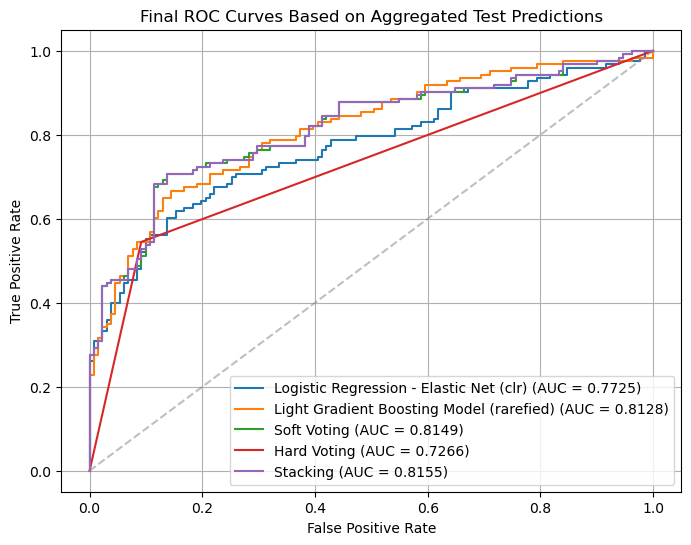


Final ROC AUCs (Cross-Derivative Ensemble):

  Logistic Regression - Elastic Net (clr) → AUC: 0.7725
  Light Gradient Boosting Model (rarefied) → AUC: 0.8128
  Soft Voting               → AUC: 0.8149
  Hard Voting               → AUC: 0.7266
  Stacking                  → AUC: 0.8155

----------------------------------------


                                  Method    AUC  Accuracy  Precision  Recall  F1 Score
 Logistic Regression - Elastic Net (clr) 0.7725    0.7205     0.7226  0.7205    0.7190
Light Gradient Boosting Model (rarefied) 0.8128    0.7480     0.7510  0.7480    0.7465
                    Soft Voting Ensemble 0.8149    0.7717     0.7742  0.7717    0.7706
                    Hard Voting Ensemble 0.7266    0.7323     0.7614  0.7323    0.7224
                       Stacking Ensemble 0.8155    0.7638     0.7655  0.7638    0.7629
All datasets processed successfully.


In [8]:
if __name__ == "__main__":
    try:
        print("Starting Ensemble Modeling...")
        main()
        print("All datasets processed successfully.")
    except Exception as e:
        print("\nFatal error occurred during ensemble evaluation.")
        print(f"{type(e).__name__}: {e}")
        raise
